<a href="https://colab.research.google.com/github/mehadisaki/Sales-Forecasting-model-development-/blob/main/ARIMA_MLP_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pmdarima

In [2]:
from pathlib import Path
import pandas as pd
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Function

##MLP

In [3]:
import numpy as np
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
#from keras.optimizers import SGD
from keras.optimizers import gradient_descent_v2
from sklearn.model_selection import TimeSeriesSplit
from keras.constraints import maxnorm
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import tensorflow as tf
#from Models.Misc import *
from sklearn.model_selection import RandomizedSearchCV
import keras.backend as K


SGD = gradient_descent_v2


tf.random.set_seed(123)




def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Function to convert a time series into a supervised learning problem.
    ...

    Attributes
    ----------
    df : Dataframe
        Dataframe of stock data.
    attribute : list
        List of columns used for creating the supervised learning problem. 
    list_of_prev_t_instants : list
    
    df : list
    
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy



def find_input_dim(data):
    
    """
    Function to find the number of terms above 0.9 autocorrelation in a data set.
    ...

    Attributes
    ----------
    data : list, Dataframe
    
    """
    
    acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(data,
                                                                 adjusted=True,
                                                                 nlags=500,
                                                                 qstat=True,
                                                                 fft=True,
                                                                 alpha = 0.05)
    
    plt.figure(figsize=(7, 5))
    plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
    plt.title('Autocorrelation of Delivery Qty', weight='bold', fontsize=16)
    plt.xlabel('Lag', weight='bold', fontsize=14)
    plt.ylabel('Value', weight='bold', fontsize=14)
    plt.xticks(weight='bold', fontsize=12, rotation=45)
    plt.yticks(weight='bold', fontsize=12)
    plt.grid(True)
    
    input_dim = sum([1 for x in acf_djia if x>0.9])
    print("Number of values above 0.9 autocorrelation is: ", input_dim)
    return input_dim



def build_baseline_model(num_of_input):
    
    """
    Function to build the baseline model.
    ...

    Attributes
    ----------
    num_of_input : int
        Dimension of the input layer.
    
    """
    
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=num_of_input, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def get_mlp_model(input_dim, hidden_layer_one=50, hidden_layer_two=25,
    dropout=0.2, learn_rate=0.01):
    
    """
    Function to build the MLP model. The parameters of the model will be optimised by the optimize_parameters() function.
    ...

    Attributes
    ----------
    input_dim: int
        Dimension of the input layer.
    hidden_layer_one: int
        Size of the first hidden layer. Default value = 50.
    hidden_layer_two: int
        Size of the second hidden layer. Default value = 25.
    dropout: float
        Rate of dropout of the dropout layer. Default value = 0.2.
    learn_rate: float
        Amount of learning rate. Default value = 0.01.
        
    """
    
    # initialize a sequential model and add layer to flatten the
    # input data
    model = Sequential()
    #model.add(Flatten())
    
    model.add(Dense(hidden_layer_one, activation="relu",
        input_dim=input_dim))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_layer_two, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=learn_rate),
        loss="mean_squared_error",
        metrics=["mse", "mae"])
    # return compiled model
    return model
    



    
def baseline_test(n_iter, input_dim, X_train, y_train, X_valid, y_valid, X_test, y_test, scaler):
    
    
    """
    Function to fit the baseline model and make prediction for n_iter amount of times.
    ...

    Attributes
    ----------
    n_iter: int
        Number of times the baseline test is ran.
    input_dim: int
        Dimension of the input layer.
    X_train: list
    y_train: list
    X_valid: list
    y_valid: list
    X_test: list
    y_test: list
    scaler: Scaler object
    
    """
        
    baseline_MSE=[]
    baseline_MAE=[]
        
    
    for i in range(n_iter):
        model = build_baseline_model(input_dim)
        # train the network (i.e., no hyperparameter tuning)
        print("[INFO] training model...")
        H = model.fit(x=X_train, y=y_train,
            validation_data=(X_valid, y_valid),
            batch_size=128,
            epochs=100, verbose=0, shuffle=False)
            # mke predictions on the test set and evaluate it
        
        
        baseline_pred = model.predict(X_test)
        baseline_pred_rescaled = scaler.inverse_transform(baseline_pred)
        
        
        #plot_comparison_graph(y_test, baseline_pred_rescaled)
        #plot_loss(H)
        
        measures = calculate_error_measures(y_test, baseline_pred_rescaled)
        baseline_MSE.append(measures[0])
        baseline_MAE.append(measures[1])
        
        K.clear_session()
    
    

    return sum(baseline_MSE)/n_iter, sum(baseline_MAE)/n_iter




def optimize_parameters(model, grid, X_train, y_train):
    
    """
    Function to optimise the MLP hyperparameters using RandomizedSearchCV. 
    ...

    Attributes
    ----------
    model: KerasRegressor object
        The model to be optimised. Wrapped in a KerasRegressor object for compatibility with the sklearn library.
    grid: dictionary
        Dictionary of list with the hyperparameter values used for optimisation.
    X_train: list
    y_train: list
        
    """
    
    tss = TimeSeriesSplit(n_splits=10)
    
    
    print("[INFO] performing random search...")
    searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, n_iter=10, cv=tss,
        param_distributions=grid, scoring=('neg_mean_squared_error','neg_mean_absolute_error'), refit='neg_mean_squared_error')
    search_results = searcher.fit(X_train, y_train)
    best_params = search_results.best_params_
    print("Best parameters are: {}".format(best_params))
    
    return best_params







##Hybrid

In [4]:
#from Models.Misc import *
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



def forecast_HMLP_residuals(input_dim_hybrid, X_train, y_train, X_valid, y_valid, X_test):
    
    """
    Function to build the HMLP and forecast the residuals.
    ...

    Attributes
    ----------
    input_dim_hybrid: int
        Dimension of the input layer for the HMLP.
    X_train: list
    y_train: list
    X_valid: list
    y_valid: list
    X_test: list
    
    """
    #
    ## define model
    model = Sequential()
    model.add(Dense(input_dim_hybrid, activation='tanh', input_dim=input_dim_hybrid))
    model.add(Dense(input_dim_hybrid/2, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(
            optimizer=Adam(learning_rate=0.01),
            loss="mean_squared_error",
            metrics=["mse", "mae"])
    
    model.summary()
    
    history_hybrid = model.fit(X_train, y_train,
                               validation_data=(X_valid, y_valid),
                               batch_size=32,
                               epochs=100, verbose=False)
    
    pred_HMLP = model.predict(X_test)
    
    return pred_HMLP, history_hybrid


def zero_centre(prediction):
    
    """
    Function to zero center the hybrid prediction.
    ...

    Attributes
    ----------
    prediction : list
    
    """
    
    if prediction[0] < 0:
        prediction = [abs(prediction[0])+i for i in prediction]
    if prediction[0] > 0:
        prediction = [i-prediction[0] for i in prediction]
    else:
        return prediction
    return prediction



##Misc

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import time



def calculate_error_measures(X, Y):
    
    """
    Function to calculate the mean squared error, mean absolute error and the coefficient of determination (r2) between two lists.
    ...

    Attributes
    ----------
    X : list
    
    Y : list
    
    """
    
        
    MSE = mean_squared_error(X, Y)
    print('Mean Squared Error: ', MSE)
    
    MAE = mean_absolute_error(X, Y)
    print('Mean Absolute Error: ', MAE)
        
    error_measures = [MSE, MAE]
    return error_measures



def create_train_valid_test(data, test_set_size, valid_set_size):
    
    """
    Function to split a dataset into training, testing and validation sets.
    ...

    Attributes
    ----------
    data : list
        
    test_set_size : int
        Int <= 1 for size of test set.
        
    valid_set_size : int
        Int <= 1 for size of validation set.   
    """
    
    
    df_copy = data.reset_index(drop=True)
    
    df_test = df_copy.iloc[ int((len(df_copy)*(1-test_set_size))) : ]
    df_train_plus_valid = df_copy.iloc[ : int((len(df_copy)*(1-test_set_size))) ]
    
    df_train = df_train_plus_valid.iloc[ : int((len(df_train_plus_valid)*(1-valid_set_size))) ]
    df_valid = df_train_plus_valid.iloc[ int((len(df_train_plus_valid)*(1-valid_set_size))) : ]
    
    X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
    X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
    X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]
    
    
    
    print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
    print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
    print('Shape of test inputs, test target:', X_test.shape, y_test.shape)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test


def scale_data(X_train, y_train, X_valid, y_valid, X_test, y_test, scaler):
    
    """
    Function to transform features by scaling them into a range a given range. A range of 0-1 is used for this project.
    ...

    Attributes
    ----------
    X_train : list
    
    y_train : list
    
    X_valid : list
    
    y_valid : list
        
    X_test : list
    
    y_test : list
    
    scaler : MinMaxScaler
    """
    
    
    X_train_scaled = scaler.fit_transform(np.array(X_train))
    X_valid_scaled = scaler.fit_transform(np.array(X_valid))
    X_test_scaled = scaler.fit_transform(np.array(X_test))
    
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
    y_valid_scaled = scaler.fit_transform(np.array(y_valid).reshape(-1,1))
    y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1,1))
    
    return X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled


def plot_comparison_graph(actual, prediction):
    
    """
    Function to plot a graph comparing the actual values to predicted values.
    ...

    Attributes
    ----------
    actual : list
    
    prediction : list   
    """
    timestamp = time.time()
    
    y_actual = pd.DataFrame(actual, columns=['Actual Delivery'])

    y_hat = pd.DataFrame(prediction, columns=['Predicted Delivery'])
    
    
    plt.figure(figsize=(11, 6))
    plt.plot(y_actual, linestyle='solid', color='r')
    plt.plot(y_hat, linestyle='dashed', color='b')
    
    plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
    plt.title('32" TV delivery', weight='bold', fontsize=16)
    plt.ylabel('Pcs', weight='bold', fontsize=14)
    plt.xlabel('Test Set Month no.', weight='bold', fontsize=14)
    plt.xticks(weight='bold', fontsize=12, rotation=45)
    plt.yticks(weight='bold', fontsize=12)
    plt.grid(True)
    
    #plt.savefig('Reports/{}.png'.format(timestamp))
    
    plt.show()
    
    
def plot_loss(history):
    
    """
    Function to plot the training and validation loss of the MLP model.
    ...

    Attributes
    ----------
    history :  History object  
    """
    
    plt.figure(figsize=(11, 6))
    history_dict=history.history
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    plt.plot(loss_values,'bo',label='Training loss')
    plt.plot(val_loss_values,'r',label='Validation loss')
    plt.legend()
    
    
    
def load_data(ETF):
    
    """
    Function to load the ETF data from a file, remove NaN values and set the Date column as index.
    ...

    Attributes
    ----------
    ETF : filepath
    """
    
    
    data = pd.read_csv(ETF, usecols=[0,4], parse_dates=[0], header=0)

    data.dropna(subset = ['Close', 'Date'], inplace=True)
    
    data_close = pd.DataFrame(data['Close'])
    data_close.index = pd.to_datetime(data['Date'])
    
    return data_close



def equal_size(list1, list2):
    
    """
    Function to equalise the size of two lists.
    ...

    Attributes
    ----------
    list1: list
    list2: list
    
    """
    
    if len(list1) > len(list2):
        s = len(list1)-len(list2)
        list1 = list1[:-s]
        return list1, list2
    if len(list2) > len(list1):
        s = len(list2)-len(list1)
        list2 = list2[:-s]
        return list1, list2
    else:
        return list1, list2
        


##ARIMA

In [6]:
from pmdarima.arima import ndiffs
import statsmodels.tsa.arima.model as sm
import matplotlib.pyplot as plt
import pandas as pd
#from statsmodels.tsa.arima import ARIMA
from statsmodels.tsa.arima.model import ARIMA 
import time
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)



def find_differencing (train_data):
    
    """
    Function to find the maximum differencing from two unit tests - ADF and KPSS.
    ...

    Attributes
    ----------
    train_data : list
    
    """
    
    
    kpss_diffs = ndiffs(train_data, alpha=0.05, test='kpss', max_d=5)
    adf_diffs = ndiffs(train_data, alpha=0.05, test='adf', max_d=5)
    n_diffs = max(adf_diffs, kpss_diffs)
    
    print(f"Estimated differencing term: {n_diffs}")
    return n_diffs


def stepwise_ARIMA(train_data, test_data, optimal_order):
    
    """
    Function to perform stepwise ARIMA forecasting.
    ...

    Attributes
    ----------
    train_data : list
    
    test_data : list
    
    optimal_order : tuple
        Optimal order of the ARIMA model, determined by the auto_arima function in the pmdarima library.
   
    """
    
    history = [x for x in train_data]
    model_predictions = []
    N_test_observations = len(test_data)
    for time_point in range(N_test_observations):
        model = ARIMA(history, order=optimal_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        model_predictions.append(yhat)
        true_test_value = test_data[time_point]
        history.append(true_test_value)
    return model_predictions
    
    
def ARIMA_pred(train_data, test_data, optimal_order):
    
    """
    Function to perform an ARIMA forecast and plot the results.
    ...

    Attributes
    ----------
    train_data : list
    
    test_data : list
    
    optimal_order : tuple
        Optimal order of the ARIMA model, determined by the auto_arima function in the pmdarima library.
   
    """
    timestamp = time.time()

    
    # Build Model
    model = ARIMA(train_data, order=optimal_order)  
    fitted = model.fit()  
    print(fitted.summary())
        
    # Forecast
    #fc, se, conf = fitted.forecast(len(test_data), alpha=0.10)
    fcast = fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()
    # Make as pandas series
    #fc_series = pd.Series(fc, index=test_data.index)
    #lower_series = pd.Series(conf[:, 0], index=test_data.index)
    #upper_series = pd.Series(conf[:, 1], index=test_data.index)
    
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.grid(True)
    plt.plot(train_data, label='training')
    plt.plot(test_data, label='actual')
    plt.plot(fcast['mean'],'g--', label='mean_forecast')
    #plt.plot(fc_series, label='forecast')
    #plt.fill_between(lower_series.index, lower_series, upper_series, 
                     #color='k', alpha=0.15)
    plt.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    
    #plt.savefig('Reports/{}.png'.format(timestamp))

    
    plt.show()
    
    return fcast


# Preperation

Data adding

In [10]:
url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/TV%20Delivery_2016-2022.xlsx?raw=true'
#url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/walton%20TV%20Delivery_2016-2022-m.xlsx?raw=true'
# taking link from view raw'

## indexing with datetime
df =pd.read_excel(url,index_col='Month',parse_dates=['Month'])
df.sort_index(inplace = True)
df32= df[['Delivery']].loc[df["SIZE"] == "32\" ( 813 mm )"]
#df32.reset_index(inplace=True)
#data_close  = df32.rename(columns = {'index':'date'})
data_close = df32

In [60]:
data_close.describe

<bound method NDFrame.describe of             Delivery   datetime
Month                          
2016-01-01      4513 2016-01-01
2016-02-01      5225 2016-02-01
2016-03-01      5583 2016-03-01
2016-04-01      5493 2016-04-01
2016-05-01      4864 2016-05-01
...              ...        ...
2021-11-01     18689 2021-11-01
2021-12-01     15909 2021-12-01
2022-01-01     22520 2022-01-01
2022-02-01     26059 2022-02-01
2022-03-01     24387 2022-03-01

[75 rows x 2 columns]>

##Plot the Delivery data

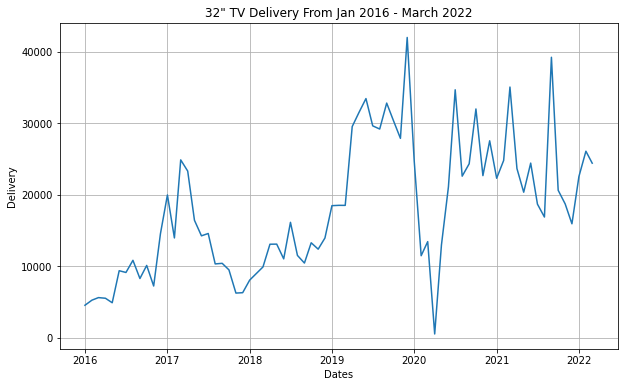

In [12]:

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Delivery')
plt.plot(data_close['Delivery'])
plt.title('32" TV Delivery From Jan 2016 - March 2022')
plt.show()

 Find the input dimention for slpiting

Number of values above 0.9 autocorrelation is:  1


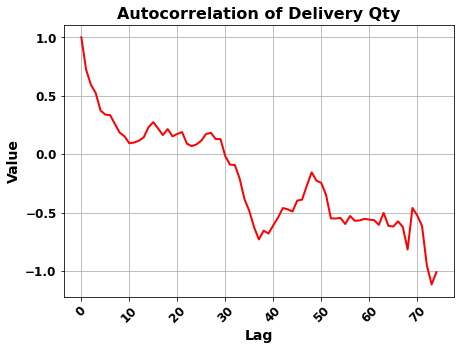

In [13]:
input_dim = find_input_dim(data_close['Delivery'])

## Data Split

In [14]:
data_copy = data_close.copy()

train_data, test_data = train_test_split(data_copy.iloc[input_dim:], test_size=0.10, shuffle = False)

print(train_data)
print(test_data)

            Delivery
Month               
2016-02-01      5225
2016-03-01      5583
2016-04-01      5493
2016-05-01      4864
2016-06-01      9344
...              ...
2021-03-01     35036
2021-04-01     23637
2021-05-01     20327
2021-06-01     24397
2021-07-01     18657

[66 rows x 1 columns]
            Delivery
Month               
2021-08-01     16855
2021-09-01     39200
2021-10-01     20594
2021-11-01     18689
2021-12-01     15909
2022-01-01     22520
2022-02-01     26059
2022-03-01     24387


# Model

## ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1324.399, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1323.020, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1322.388, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1322.478, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1324.295, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1320.566, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1320.481, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1321.167, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1317.415, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1321.821, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1319.409, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1318.9

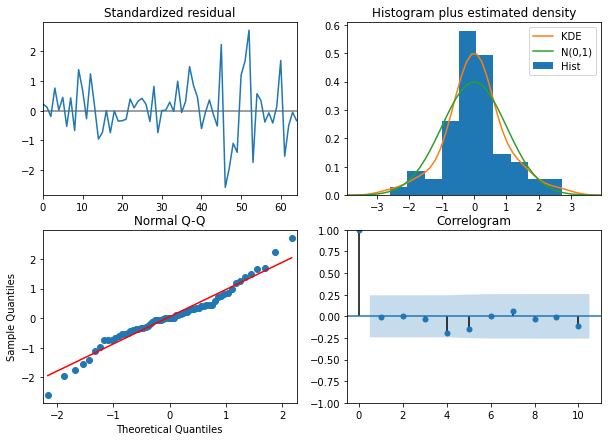

In [15]:
arima_model_order =  auto_arima(train_data,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, test='kpss', seasonal_test='ocsb', error_action='warn',
                          trace = True, supress_warnings=True,stepwise = True,
                          random_state=None, n_fits = 50)

arima_model_order.plot_diagnostics(figsize=(10,7))
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:               Delivery   No. Observations:                   66
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -654.707
Date:                Fri, 22 Apr 2022   AIC                           1317.415
Time:                        03:50:57   BIC                           1326.113
Sample:                    02-01-2016   HQIC                          1320.847
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0975      0.104    -10.592      0.000      -1.301      -0.894
ar.L2         -0.3360      0.114     -2.944      0.003      -0.560      -0.112
ma.L1          0.9812      0.138      7.133      0.0

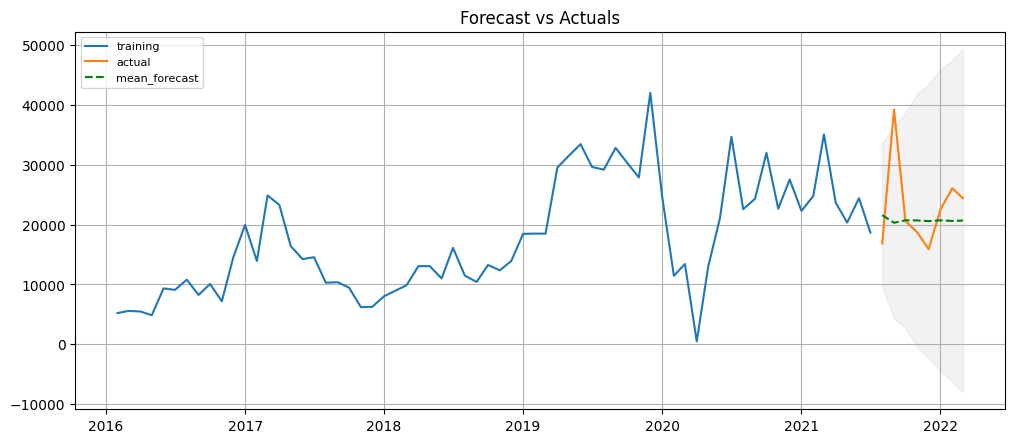

In [16]:
fc = ARIMA_pred(train_data, test_data, arima_model_order.order)

In [17]:
print("Error measures for ARIMA:")
calculate_error_measures(test_data, fc['mean'])

Error measures for ARIMA:
Mean Squared Error:  56497656.78582001
Mean Absolute Error:  5172.156383468375


[56497656.78582001, 5172.156383468375]

In [22]:
fc

Delivery,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-08-01,21565.309743,6124.503157,9561.504133,33569.115353
2021-09-01,20302.255472,8162.155950,4304.723775,36299.787170
2021-10-01,20711.183699,9150.985754,2775.581199,38646.786199
2021-11-01,20686.801908,10814.532499,-509.292300,41882.896115
2021-12-01,20576.154817,11676.090666,-2308.562369,43460.872003
2022-01-01,20705.778793,12843.278611,-4466.584728,45878.142314
2022-02-01,20600.699821,13699.404984,-6249.640557,47451.040198
2022-03-01,20672.465013,14613.741485,-7969.941977,49314.872003


## MLP

In [53]:
columns_mlp = ['Delivery']

n_lags_mlp = []
for i in range(1, input_dim+1):
    n_lags_mlp.append(i)

df_new = create_regressor_attributes(data_close, columns_mlp, n_lags_mlp)

df_new.shape

(74, 2)

In [ ]:
df_new.head()

### Split for MLP

In [54]:
X_train, y_train, X_valid, y_valid, X_test, y_test = create_train_valid_test(df_new, 0.10, 0.10)

Shape of training inputs, training target: (59, 1) (59,)
Shape of validation inputs, validation target: (7, 1) (7,)
Shape of test inputs, test target: (8, 1) (8,)


Scaling

In [55]:
scaler = MinMaxScaler()

X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled = scale_data(X_train, y_train, X_valid, y_valid, X_test, y_test, scaler)

In [56]:
y_test_rescaled = scaler.inverse_transform(y_test_scaled)

In [ ]:
baseline_test(10, input_dim, X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_rescaled, scaler)

In [ ]:
# wrap model into a scikit-learn compatible regressor
model = KerasRegressor(build_fn=get_mlp_model, verbose=0, input_dim=input_dim)
# define a grid of the hyperparameter search space
hidden_layer_one = [25, 50, 100]
hidden_layer_two = [5, 10, 25]
learn_rate = [0.01, 0.001, 0.0001]
dropout = [0.1, 0.2 , 0.3, 0.4, 0.5]
batch_size = [4, 8, 16, 32, 64, 128]
epochs = [10, 50, 100, 500, 1000]
# create a dictionary from the hyperparameter grid
grid = dict(
    hidden_layer_one=hidden_layer_one,
    hidden_layer_two=hidden_layer_two,
    dropout=dropout,
    learn_rate=learn_rate,
    batch_size=batch_size,
    epochs=epochs
)

In [ ]:
best_parameters = optimize_parameters(model, grid, X_train_scaled, y_train_scaled)


hidden_layer_one=best_parameters['hidden_layer_one']
hidden_layer_two=best_parameters['hidden_layer_two']
dropout=best_parameters['dropout']
learn_rate=best_parameters['learn_rate']
batch_size=best_parameters['batch_size']
epochs=best_parameters['epochs']


best_model = get_mlp_model(input_dim, hidden_layer_one=hidden_layer_one, hidden_layer_two=hidden_layer_two,
    dropout=dropout, learn_rate=learn_rate)

In [ ]:
#
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 0, patience = 25, verbose=1, restore_best_weights=True)


history = best_model.fit(x=X_train_scaled, y=y_train_scaled,
    validation_data=(X_valid_scaled, y_valid_scaled),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=es,
    shuffle=False,
    verbose=False)

MLP_pred = best_model.predict(X_test_scaled)
MLP_pred_rescaled = scaler.inverse_transform(MLP_pred)

In [ ]:
plot_comparison_graph(y_test_rescaled, MLP_pred_rescaled)
plot_loss(history)

print("Error measures for MLP:")
calculate_error_measures(y_test_rescaled, MLP_pred_rescaled)

In [ ]:
plot_model(best_model,
    #to_file="Reports/MLP.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=96)

## Hybrid

### Statistical model

In [37]:
train_data2, test_data2 = train_test_split(data_copy, test_size=0.20, shuffle = False)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1199.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1199.401, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1199.161, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1198.084, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1201.021, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.261 seconds


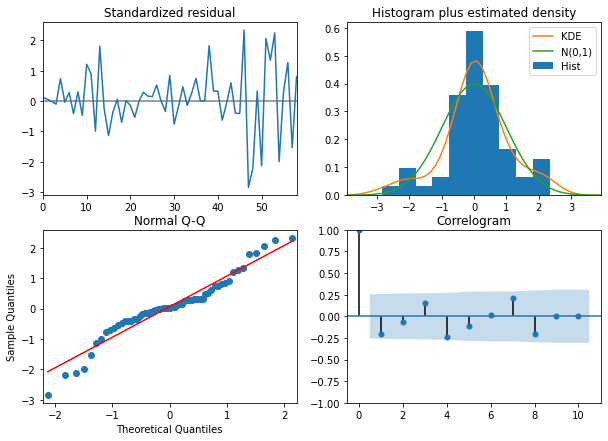

In [38]:
arima_model_order2 =  auto_arima(train_data2,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, test='kpss', seasonal_test='ocsb', error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=None, n_fits = 50)

arima_model_order2.plot_diagnostics(figsize=(10,7))
plt.show()

### Residue

Collecting residue from Statistical analysis like ARIMA for Machine learning model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Delivery   No. Observations:                   60
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -598.042
Date:                Fri, 22 Apr 2022   AIC                           1198.084
Time:                        04:16:01   BIC                           1200.161
Sample:                    01-01-2016   HQIC                          1198.895
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.668e+07    5.5e+06      6.670      0.000    2.59e+07    4.75e+07
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):                 3.16
Prob(Q):                              0.11   Pr

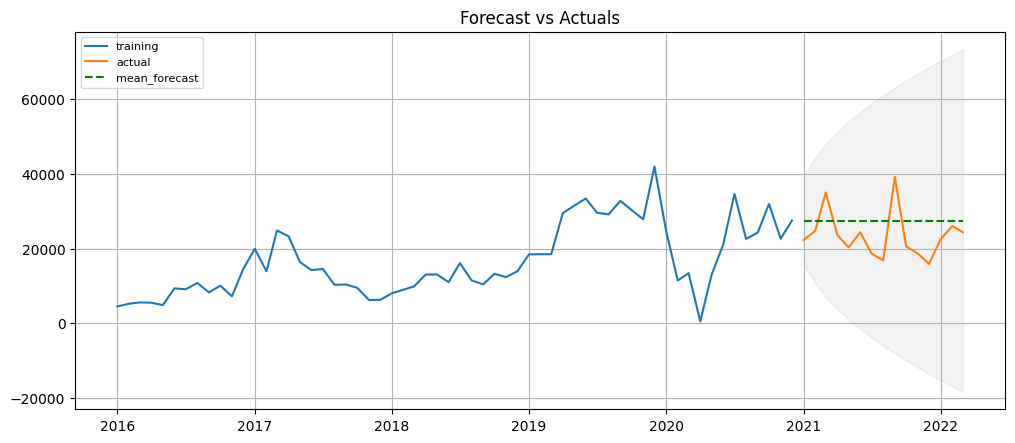

In [39]:
fc_resid = ARIMA_pred(train_data2, test_data2, arima_model_order2.order)

residuals = [a-b for a,b in zip(test_data2['Delivery'], fc_resid['mean'])]

resid = pd.DataFrame(residuals, columns = ['resid'])

In [40]:
resid.head()

,resid
0,-5239.0
1,-2753.0
2,7517.0
3,-3882.0
4,-7192.0


### Input dimention for ML

Number of values above 0.9 autocorrelation is:  1


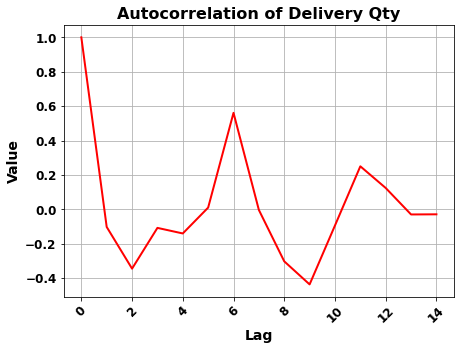

In [41]:
input_dim_hybrid = find_input_dim(resid['resid'])

### MLP 

In [42]:

column_hybrid = ['resid']

n_lags_hybrid = []
for i in range(1, input_dim_hybrid+1):
    n_lags_hybrid.append(i)

df_new_hybrid = create_regressor_attributes(resid, column_hybrid, n_lags_hybrid)

In [43]:
df_new_hybrid.head()

,resid,resid_(t-1)
datetime,,
1,-2753.0,-5239.0
2,7517.0,-2753.0
3,-3882.0,7517.0
4,-7192.0,-3882.0
5,-3122.0,-7192.0


Split


In [44]:
scaler = MinMaxScaler()
X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = create_train_valid_test(
    df_new_hybrid, 0.20, 0.10)


X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid = scale_data(
    X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid, y_test_hybrid, scaler)

Shape of training inputs, training target: (9, 1) (9,)
Shape of validation inputs, validation target: (2, 1) (2,)
Shape of test inputs, test target: (3, 1) (3,)


In [57]:
y_test_rescaled = scaler.inverse_transform(y_test_scaled)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
 dense_4 (Dense)             (None, 0)                 0         
                                                                 
 dropout_1 (Dropout)         (None, 0)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


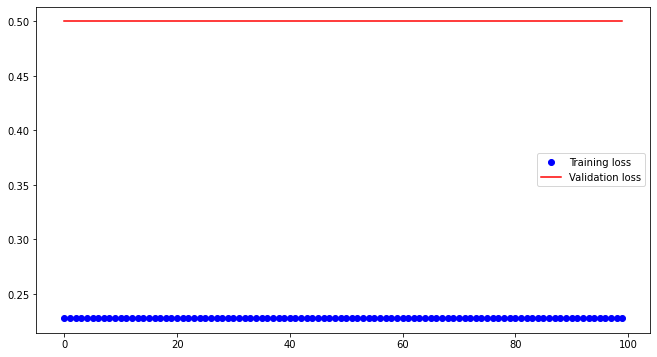

In [45]:
resid_HMLP, history_hybrid = forecast_HMLP_residuals(
    input_dim_hybrid, X_train_hybrid, y_train_hybrid, X_valid_hybrid, y_valid_hybrid, X_test_hybrid)

resid_HMLP = scaler.inverse_transform(resid_HMLP)


plot_loss(history_hybrid)

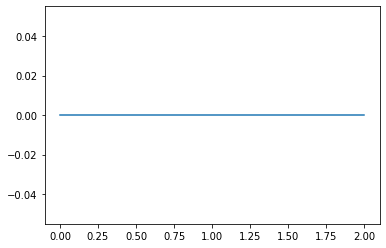

In [58]:
resid_HMLP = zero_centre(resid_HMLP)

plt.plot(resid_HMLP)
plt.show()

In [49]:
#List comprehension to combine ARIMA and HMLP forecast.
pred_hybrid = [a+b for a,b in zip(fc['mean'], resid_HMLP)]

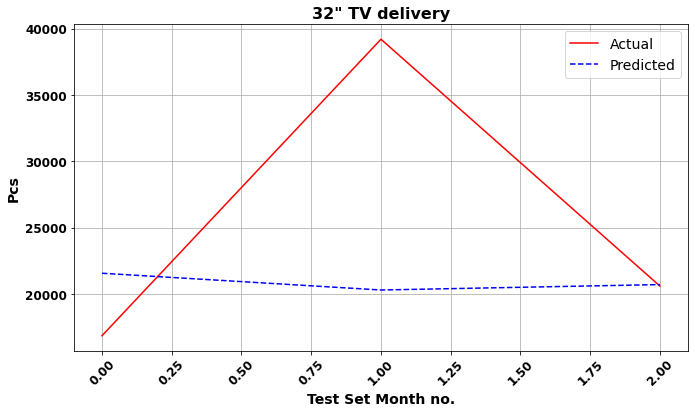

Error measures for Hybrid:
Mean Squared Error:  126441830.34905751
Mean Absolute Error:  7908.412760416667


[126441830.34905751, 7908.412760416667]

In [59]:
y_test_rescaled, pred_hybrid = equal_size(y_test_rescaled, pred_hybrid)

plot_comparison_graph(y_test_rescaled, pred_hybrid)

print("Error measures for Hybrid:")
calculate_error_measures(y_test_rescaled, pred_hybrid)